In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dados

**Samples**: array 224x224x3 de amostras de imagens (RGB)

**Labels**: array 1x1 com as classes das amostras em string (shiny, rainy, cloudy, foggy, sunrise)

**transform_labels**: transforma os labels no formato one-hot-encoding (ex: [0, 0, 1, 0, 0])

**get_data**: retorna todos os dados no formato correto para submeter aos modelos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data():
    samples = np.load('/content/drive/MyDrive/IFC/8º Semestre/Trabalho de Curso II/dataset/weather_samples.npy')
    labels = np.load('/content/drive/MyDrive/IFC/8º Semestre/Trabalho de Curso II/dataset/weather_labels.npy')
    return samples, labels

In [ ]:
def transform_labels(labels):
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(y=labels)
    return labels

In [ ]:
def get_data():
  samples, labels = load_data()
  return samples, transform_labels(labels)

# Utils

**get_int_classes**: retorna um array de inteiros com base no valores one-hot-encoding passados

**show_sample**: imprime o label e retorna a imagem da amostra fornecida

In [ ]:
def get_int_classes(y):
  return [np.argmax(i) for i in y]

In [ ]:
def show_sample(sample, label):
  classes = ['Cloudy', 'Foggy', 'Rainy', 'Shiny', 'Sunrise']
  label_index = get_int_classes([label])[0]
  print(classes[label_index])
  print(label)
  return Image.fromarray(sample, 'RGB')

# Modelos

**create_model**: cria o modelo com o número de neurônios especificados por parâmetro

**save_model**: salva a modelo criado juntamente dos pesos, gerando arquivos .h5 e .json

**train_model**: treina o modelo passado por parâmetro utilizando Data Augmentation

**load_model**: carrega e compila o modelo previamente salvo

In [ ]:
def create_model(output = 5):
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(output, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  return model

In [ ]:
def train_model(X, y, model, epochs):
  batch_size = 32
  datagen = ImageDataGenerator(rotation_range=20,
                             zoom_range=0.15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip=True,
                             fill_mode="nearest")
  datagen.fit(X)
  history = model.fit(datagen.flow(X, y, batch_size=32),
                      epochs=epochs,
                      steps_per_epoch=len(X) // batch_size,
                      batch_size=128)
  return history

In [ ]:
def save_model(model):
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights("model.h5")

In [ ]:
def load_model(name = 'ics_model'):
  model = None
  path = '/content/drive/MyDrive/IFC/8º Semestre/Trabalho de Curso II/models/' + name
  with open(path + '/model.json', 'r') as json_file:
    model = model_from_json(json_file.read())
    model.load_weights(path + '/model.h5')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  return model

# Avaliações

Imprime a acurácia, acurácia balanceada, área abaixo da curva roc e a matriz de confusão

In [ ]:
def evaluate(y, y_pred):
  gt = [np.argmax(i) for i in y]
  pred = [np.argmax(i) for i in y_pred]

  acc = metrics.accuracy_score(gt, pred)
  bacc = metrics.balanced_accuracy_score(gt, pred)

  print('Acurácia: %s\nAcurácia balanceada: %s' % (acc, bacc))

  roc_auc_score = metrics.roc_auc_score(y, y_pred, average='micro', multi_class='ovo')

  print('ROC AUC SCORE: %s' % roc_auc_score)

  cm = metrics.confusion_matrix(gt, pred)
  cm_disp = metrics.ConfusionMatrixDisplay(cm)
  cm_disp.plot()

  # fp = cm.sum(axis=0) - np.diag(cm)  
  # fn = cm.sum(axis=1) - np.diag(cm)
  # tp = np.diag(cm)
  # tn = cm.sum() - (fp + fn + tp)

  # tpr = tp / (tp + fn)
  # tnr = tn / (tn + fp)
  # fpr = fp / (fp + tn)

# Intra-class Splitting

**intra_class_split**: divide as amostras em **típicas** e **atípicas** com base no score de similaridade com as respetivas classes de cada amostra

In [ ]:
def intra_class_split(y, pred, rho):
  y_pred = to_categorical(y=get_int_classes(pred))

  sim_score = y * y_pred * pred
  sim_score = np.max(sim_score, axis=-1)
  sim_thr = np.percentile(sim_score, rho)

  typical_indexes = np.where(sim_score > sim_thr)[0]
  atypical_indexes = np.where(sim_score <= sim_thr)[0]

  return typical_indexes, atypical_indexes

# Classificação de conjunto aberto

**get_new_labels**: retorna os novos labels modificando as classes desconhecidas para 0

**split_osr_data**: retorna amostras divididas para treinar e testar o classificador de conjunto aberto

**train_osr_model**: retorna o modelo treinado e o histórico

# Divisão das amostras para OSR

* ### Treino:
 * Apenas amostras típicas conhecidas
 * Amostras atípicas (alterar a classe para 0)

* ### Treino:
 * Amostras típicas conhecidas
 * Amostras típicas desconhecidas (alterar a classe para 0)

In [ ]:
def get_new_labels(y, unknown_classes):
  new_labels = get_int_classes(y)
  new_labels = [-1 if i in unknown_classes else i for i in new_labels]
  new_labels = np.array(new_labels)
  new_labels = new_labels + 1

  unique_classes = np.unique(new_labels)

  for i, v in enumerate(new_labels):
    new_labels[i] = np.where(v == unique_classes)[0]

  return to_categorical(y=new_labels)

In [ ]:
def split_osr_data(X, y, typical_indexes, atypical_indexes, unknown_classes):
  int_labels = get_int_classes(y)
  total_samples = len(X)

  typical_known_indexes = []
  typical_unknown_indexes = []

  for i in typical_indexes:
    if int_labels[i] not in unknown_classes:
      typical_known_indexes.append(i)
    else:
      typical_unknown_indexes.append(i)

  typical_known_indexes = shuffle(typical_known_indexes)

  train_indexes_limit = int((len(typical_known_indexes) + len(atypical_indexes)) * 0.7)

  train_indexes = typical_known_indexes[:train_indexes_limit]
  test_indexes = typical_known_indexes[train_indexes_limit:]

  for i in typical_unknown_indexes:
    test_indexes.append(i)

  for i in atypical_indexes:
    train_indexes.append(i)

  return X[train_indexes], get_new_labels(y[train_indexes], unknown_classes), X[test_indexes], get_new_labels(y[test_indexes], unknown_classes)

# Experimento nº 1: desenvolvimento do modelo ICS

## Treinamento

In [ ]:
X, y = get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
ics_model = create_model(5)
history = train_model(X_train, y_train, ics_model, epochs=300)

## Teste e avaliação

Acurácia: 0.9117647058823529
Acurácia balanceada: 0.9096017772750751
ROC AUC SCORE: 0.9890319962407621


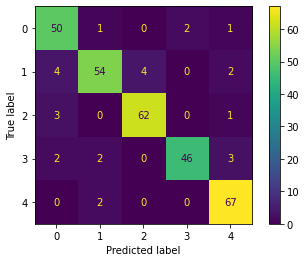

In [ ]:
pred = ics_model.predict(X_test)
evaluate(y_test, pred)

In [ ]:
save_model(ics_model)

# Experimento nº 2: *intra-class splitting*

In [ ]:
X, y = get_data()
ics_model = load_model('ics_model')

In [ ]:
len(y)

1528

In [ ]:
pred = ics_model.predict(X)
typical_indexes, atypical_indexes = intra_class_split(y, pred, 10)
total_typical = len(typical_indexes)
total_atypical = len(atypical_indexes)
total = total_typical + total_atypical

print('Quantidade de amostras típicas: %s (%.2f%%)\nQuantidade de amostras atípicas: %s (%.2f%%)' % (total_typical, ((total_typical * 100) / total), total_atypical, ((total_atypical * 100) / total)))

Quantidade de amostras típicas: 1375 (89.99%)
Quantidade de amostras atípicas: 153 (10.01%)


# Experimento nº 3: desenvolvimento do modelo OSR

rho = 10

classes desconhecidas = 1, 2

epochs = 300

In [ ]:
X_train, y_train, X_test, y_test = split_osr_data(X, y, typical_indexes, atypical_indexes, [1, 2])
osr_model = create_model(4)
history = train_model(X_train, y_train, osr_model, 300)

In [ ]:
save_model(osr_model)

Acurácia: 0.6580459770114943
Acurácia balanceada: 0.7602235011338939
ROC AUC SCORE: 0.853337833597569


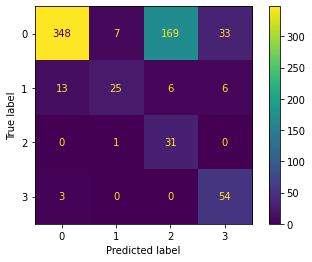

In [ ]:
osr_pred = osr_model.predict(X_test)
evaluate(y_test, osr_pred)

Rainy
[0. 0. 1. 0.]


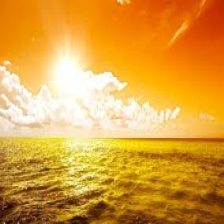

In [ ]:
index = 0

for i, v in enumerate(get_int_classes(y_test)):
  if v == 2:
    index = i
  
show_sample(X_test[index], y_test[index])